In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
from io import StringIO
from mst_clustering import MSTClustering
from amplpy import AMPL
# warnings.filterwarnings('ignore')

In [2]:
#paremeter selection

k = 3
m = 100


In [3]:
#generating points
random_state = 42
points, y = make_blobs(n_samples=m,centers = k, random_state=random_state)



Text(0.5, 1.0, 'K means solution')

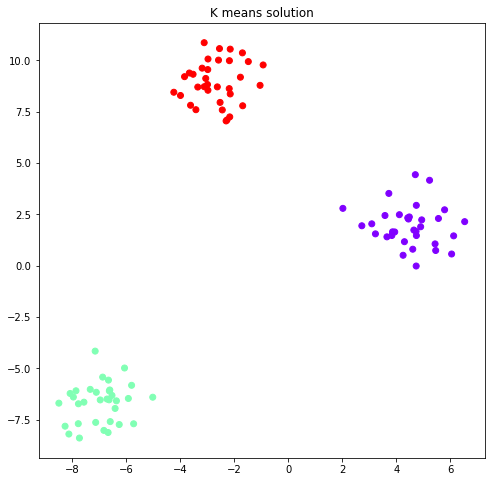

In [62]:
#Kmeans solution
random_state = 170
y_pred = KMeans(n_clusters=k, random_state=random_state).fit_predict(points)


#print clusters
plt.figure(figsize=(8, 8))


plt.scatter(points[:, 0], points[:, 1], c=y_pred,cmap='rainbow')
plt.title("K means solution")

Text(0.5, 1.0, 'MST solution')

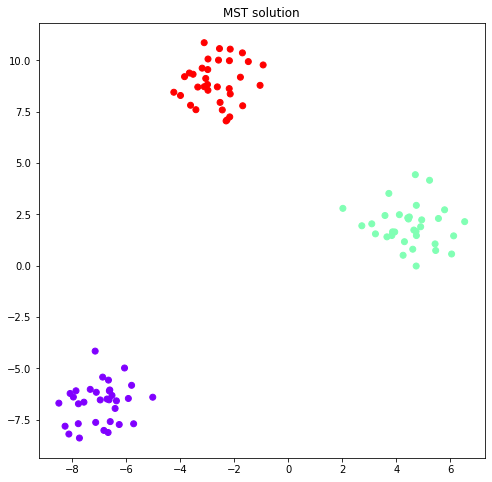

In [59]:
#MST solution
model = MSTClustering(cutoff=k-1)
y_pred_mst = model.fit_predict(points)

#print clusters
plt.figure(figsize=(8, 8))

plt.scatter(points[:, 0], points[:, 1], c=y_pred_mst, cmap='rainbow');
plt.title("MST solution")

HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 117.6816901
1534 simplex iterations
1 branching nodes
 


Text(0.5, 1.0, 'LP solution')

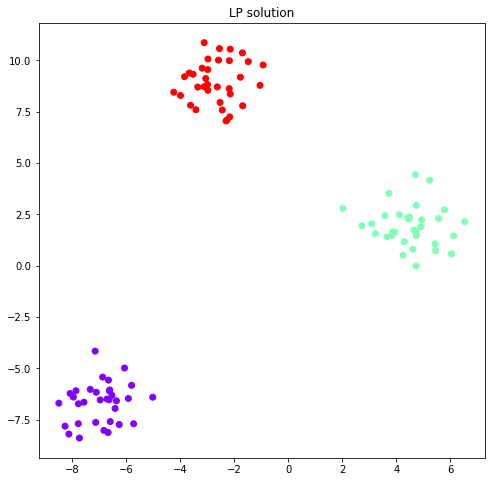

In [4]:
#AMPL solution

#generate matrix distance
dist = [[math.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2) for i in points] for j in points]

#We write the generated data in a .dat AMPL format.
output = open("Kcluster.dat", "w")
output.write('param k:= '+ str(k) + ';')
output.write('\n')
output.write('param m:= '+ str(m) + ';')
output.write('\n')
output.write('param d: ')
for i in range(m):output.write(str(i + 1) + ' ')
output.write(':=')
output.write('\n')
for i in range(m):
    output.write(str(i + 1) + ' ')
    for j in range(m):
        output.write(str(dist[i][j]))
        if(j != m-1):output.write(' ')
    if(i != m-1):output.write('\n')
output.write(';')
output.write('\n')
output.close()


ampl = AMPL()
ampl.read("Kcluster.mod")
ampl.read_data("Kcluster.dat")
ampl.option["solver"] = "highs"

ampl.solve()

#AMPL solution processing
solution_input = ampl.get_variable("x").get_values().to_pandas().values.tolist()
solution_input[0]
sol = [0 for _ in range(m)]
clusters = []
for i in range(m):
    for j in range(m):
        if solution_input[i*m + j][0] == 1:
            if not (j) in clusters: clusters.append(j)
            sol[i] = clusters.index(j)
            
#print clusters
plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], c=sol,cmap='rainbow')
plt.title("LP solution")

In [6]:
#Multidimensional dataset kmeans implementation
df = pd.read_csv('wine-clustering.csv')
kmeans = KMeans(n_clusters=3, init='k-means++', random_state= 42)  
y_predict= kmeans.fit_predict(df)

